In [25]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [26]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['nl-345215-attnR_20240201_1637_RLS.mat']
Current WD: C:\plimon\LTP_analysis\eegMatFiles\nl-345215-attnR_20240201_1637_RLS.mat
Does File #1 Exist? True


In [27]:
mat_data = scipy.io.loadmat(file_path1) # import data file
print((mat_data.keys()))

dict_keys(['__header__', '__version__', '__globals__', 'info', 'signalData', 'noise1', 'noise2'])


In [28]:
# find basic data parms 
MainData = mat_data['signalData']
noise1 = mat_data['noise1'] # 6 x 1 
noise2 = mat_data['noise2']
inds = mat_data['info'][0][0]
ExpConds = int(MainData.shape[0])
print(f'Data file contains data for {ExpConds} different conditions')

Data file contains data for 6 different conditions


### Channels to analyze derived form ryans selcted electrodes

In [29]:
elecLeftLateral=[51,52,60,58,59,64,65,68,69]
elecLeftMedial=[72,75,81,70,71,74]
elecRightMedial=[72,75,81,76,83,82]
elecMedial=[72,75,81,70,71,74,76,83,82]
elecRightLateral=[97,92,85,96,91,95,90,94,88]

In [30]:
# save signal data
FreqDataPerCo = {}
for co in range(ExpConds):
    #print(MainData[co][0].shape)
    FreqDataPerCo[co] = MainData[co][0]
# noise data 1 
Noise1DataPerCo = {}
for co in range(ExpConds):
    #print(noise1[co][0].shape)
    Noise1DataPerCo[co] = noise1[co][0]
# noise data 2
Noise2DataPerCo = {}
for co in range(ExpConds):
    #print(noise2[co][0].shape)
    Noise2DataPerCo[co] = noise2[co][0]

In [31]:
co = 0 # pre and post induction ltp
HarmInd = np.array(mat_data['info'][0][0] [0][co][0])
BinInd = np.array(mat_data['info'][0][0] [1][co][0])
HarmonLabels = mat_data['info'][0][0][2][co][0]
AvgAct = mat_data['info'][0][0] [3][co] [0]
NumCondInd = mat_data['info'][0][0][4][co][0]
HemiFieldLabels = mat_data['info'][0][0] [2][co] [0]

#########IN case some nexted arrays need to be extracted or explored
co = 0
ind = 2
inds = mat_data['info'][0][0] [ind][co] [0] # avoid prelude bind which == 0 actually 
print(inds)
for innerlist in inds:
    for item in innerlist:
        print(item)

[[array(['2F1'], dtype='<U3')]
 [array(['4F1'], dtype='<U3')]
 [array(['6F1'], dtype='<U3')]
 [array(['8F1'], dtype='<U3')]
 [array(['2F2'], dtype='<U3')]
 [array(['4F2'], dtype='<U3')]
 [array(['6F2'], dtype='<U3')]
 [array(['8F2'], dtype='<U3')]]
['2F1']
['4F1']
['6F1']
['8F1']
['2F2']
['4F2']
['6F2']
['8F2']


#### have to combine real and imaginar before data can be indexed 

In [32]:
NumHarms,NumHarmCount = np.unique(HarmInd, return_counts = True)
print(NumHarms,NumHarmCount)
NumBins,NumBinCount = np.unique(BinInd, return_counts = True)
print(NumBins,NumBinCount)

Bins = int(len(NumBins)-1)

[1 2 3 4 5 6 7 8] [7 7 7 7 7 7 7 7]
[0 1 2 3 4 5 6] [8 8 8 8 8 8 8]


In [33]:
SortDataIn =  FreqDataPerCo[0] # 112 x 128 x 78
[NumRows, NumChans, NumTrials] = SortDataIn.shape
print(SortDataIn.shape)
real_imag_bound = int((NumRows/2))
print(real_imag_bound)

prepost_bound = int(NumTrials/2)


(112, 128, 78)
56


In [36]:
SelectCo = 0
# segment data into real and imaginary data side by side
dIn = FreqDataPerCo[SelectCo].reshape(real_imag_bound,2,NumChans,NumTrials) # 56 x 2 x 128 x 78
n1 = Noise1DataPerCo[SelectCo].reshape(real_imag_bound,2,NumChans,NumTrials)
n2 = Noise2DataPerCo[SelectCo].reshape(real_imag_bound,2,NumChans,NumTrials)
dIn[dIn == 0] = np.nan
n1[n1 == 0] = np.nan
n2[n2 == 0] = np.nan

# combine real and imaginary compnents for signal data, noise 1 and noise 2 
DataOut = np.hypot(dIn[:,0,:],dIn[:,1,:]) # (56, 128, 78)
n1Out = np.hypot(n1[:,0,:],n1[:,1,:]) # (56, 128, 78)
n2Out = np.hypot(n2[:,0,:],n2[:,1,:]) # (56, 128, 78)

print(DataOut.shape)

(56, 128, 78)


In [ ]:
# # # get avg data and non avg data
# CleanData = DataOut[(BinInd[BinInd != 0]),:,:] # remove prelude bins 
# n1_c =  n1Out[(BinInd[BinInd != 0]),:,:] # remove prelude bins 
# n2_c =  n2Out[(BinInd[BinInd != 0]),:,:] # remove prelude bins 
# print(CleanData.shape)
# print(n1_c.shape)
# print(n2_c.shape)

# print(CleanData.shape)
# plt.plot(CleanData[:,90,10], label = 'signal')
# plt.plot(n1_c[:,90,10], label = 'noise1')
# plt.plot(n2_c[:,90,10], label = 'noise 2')
# plt.legend()


(8, 128, 78)
(8, 128, 78)
(8, 128, 78)
(8, 128, 78)
(8, 128, 78)
(8, 128, 78)


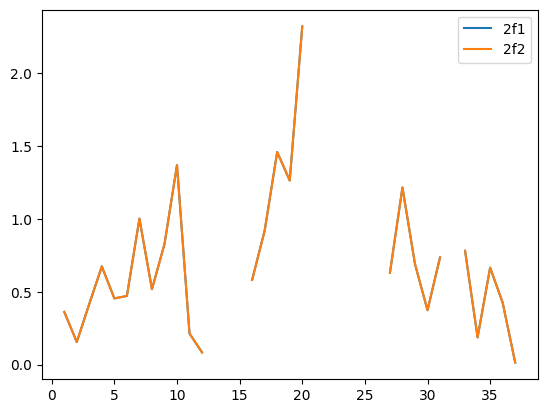

In [38]:

DataPerBin = {} # first half of data is 2f1, 4f1,6f1,8f1, 2f2,4f2,6f2,8f2
for i in range(Bins):
    #nested_bool = (HarmInd[HarmInd == i+1])
    nested_bool = (BinInd[BinInd == i+1])
    DataPerBin[i] = np.squeeze(DataOut[nested_bool,:,:])
    print(DataPerBin[i].shape)
x = 3

pre_f1 = np.mean(DataPerBin[x][:4,:,0:prepost_bound],axis = 0) # average activity across channels for 1 bin i belive 
post_f1 = np.mean(DataPerBin[x][:4,:,prepost_bound:],axis = 0)


pre_f2 = np.mean(DataPerBin[x][4:,:,0:prepost_bound],axis = 0) # average activity across channels for 1 bin i belive 
post_f2 = np.mean(DataPerBin[x][4:,:,prepost_bound:],axis = 0)


plt.plot(pre_f1[80,:], label = '2f1')
plt.plot(pre_f2[80,:], label = '2f2')
plt.legend()


In [ ]:
# MaskPreludes = BinInd!=0
# eegData = SortDataIn[MaskPreludes :, :]
# AvgData = SortDataIn[(BinInd[BinInd == 0]),:,:]
# #omitAvg[(HarmInd[HarmInd == 1]&~BinInd == 0]),:,:]) # try and ke this matrix without the averag data inside , 112 x 128 x 
# #mysteryAvg = 

# print(AvgData.shape) # 8 x 128 x 78
# #print(eegData.shape) # 48 x 128 x 78